<a href="https://colab.research.google.com/github/LisaATaylor/naip-classify/blob/master/SatelliteImagery_DataPreparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Colab contains the workflow used to obtain, prepare, and inspect the DeepSat6 dataset from Kaggle.

In [4]:
from google.colab import files
#install kaggle package
!pip install -q kaggle
#load kaggle API json from hard drive
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [17]:
#move api key to correct folder, change permissions
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [18]:
#download data to /content
!kaggle datasets download -d crawford/deepsat-sat6

100% 2.42G/2.42G [01:00<00:00, 46.2MB/s]
100% 2.42G/2.42G [01:00<00:00, 43.0MB/s]


In [19]:
#unzip
!unzip /content/*.zip

Archive:  /content/deepsat-sat6.zip
  inflating: X_test_sat6.csv         
  inflating: X_train_sat6.csv        
  inflating: sat-6-full.mat          
  inflating: sat6annotations.csv     
  inflating: y_test_sat6.csv         
  inflating: y_train_sat6.csv        


In [20]:
#save data files to google drive to avoid having to download again.
from google.colab import drive
#first connect to google drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# copy matlab-formatted data (is most compact) to google drive
!cp /content/sat-6-full.mat /content/gdrive/My\ Drive/Springboard/Data/DeepSat6/

In [0]:
#load matlab data file (image tiles)
from scipy.io import loadmat
data=loadmat('/content/gdrive/My Drive/Springboard/Data/DeepSat6/sat-6-full.mat')

In [24]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'train_x', 'test_x', 'train_y', 'test_y', 'annotations'])



---
At this point we have a dictionary containing the training and test data.  
Let's open it up and look at it.

In [0]:
import numpy as np
import pandas as pd

#Matlab format has long axis in last position, 
#This function moves the long axis to the first position (as expected by keras)
def fixaxes(inarr): 
  return np.rollaxis(inarr,3,0)

#load ndarrays from mat dictionary
trainX=fixaxes(data['train_x']) 
trainy=data['train_y'].T
testX=fixaxes(data['test_x'])
testy = data['test_y'].T

#test that the transform works
assert np.all(trainX[0,:10,0,0] == data['train_x'][:10,0,0,0])


In [60]:
#Run some checks on the data to make sure its intact

#check each image tile is assigned to a single category
print('Each training image has single category: {}'.format(np.all(trainy.sum(axis=1)==1)))
print('Each test image has single category: {}'.format(np.all(testy.sum(axis=1)==1)))


Each training image has single category: True
Each test image has single category: True


In [72]:
#test min and max values for each band are between 0 and 255, and not null

#check for nans
print('No training images contain nans: {}'.format(~np.isnan(trainX).any()))
print('No test images contain nans: {}'.format(~np.isnan(testX).any()))

#check min/max image values in range 0-255
print('Training pixels >= 0: {}'.format(np.amin(trainX)>=0))
print('Test pixels >= 0: {}'.format(np.amin(testX)>=0))
print('Training pixels <=255: {}'.format(np.amax(trainX)<=255))
print('Test pixels <= 255 : {}'.format(np.amax(testX)<=255))

No training images contain nans: True
No test images contain nans: True
Training pixels >= 0: True
Test pixels >= 0: True
Training pixels <=255: True
Test pixels <= 255 : True


0

In [0]:
#make dict for mapping category number to human-readable name
an=data['annotations']
categories=dict()
for r in range(len(an)):
  categories[r]=an[r][1][0]
#make series of readable training data results
ycat=pd.DataFrame(trainy).idxmax(axis=1).map(categories)

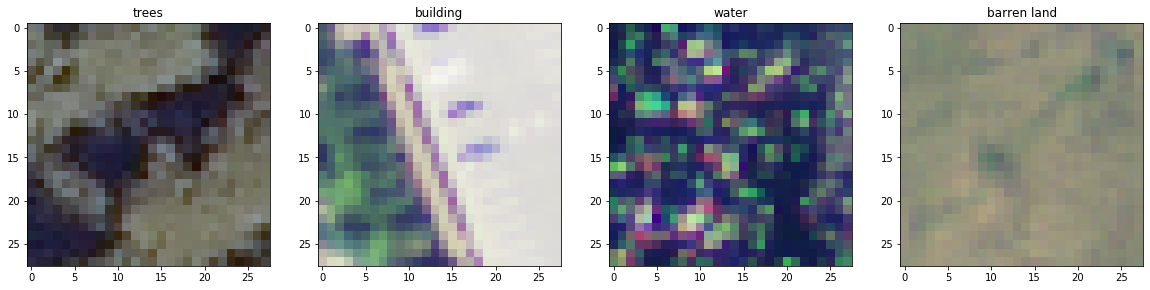

In [74]:
# look at a few tiles, visible bands
import matplotlib.pyplot as plt 
fig,axs=plt.subplots(1,4,figsize=(20,10))
axs[0].imshow(trainX[0,:,:,:3])
axs[1].imshow(trainX[6,:,:,:3])
axs[2].imshow(trainX[2,:,:,:3])
axs[3].imshow(trainX[8,:,:,:3])
axs[0].set_title(ycat.loc[0])
axs[1].set_title(ycat.loc[6])
axs[2].set_title(ycat.loc[2])
axs[3].set_title(ycat.loc[8]);

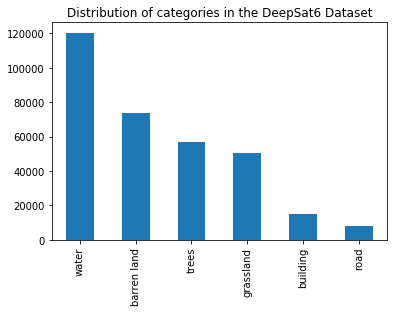

In [75]:
#look at balance between categories:  we see that the categories are not evenly distributed
ycounts=ycat.value_counts()
ycounts.plot.bar()
plt.title('Distribution of categories in the DeepSat6 Dataset');